# Boosted Decision Tree (BDT) for $H \rightarrow \rho\gamma, \phi\gamma$ Analysis

In [2]:
# General
import os, sys
# Handling ROOT files
import numpy as np
import uproot
import pandas as pd
import pickle
# Plotting
import matplotlib
from matplottery import Hist1D, Hist2D, plot_stack
import matplotlib.pyplot as plt
# Machine Learning
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import xgboost as xgb #BDT
import ast
import json
# Custom Tools
from data import GetData, WriteJSON, JSONtoC
# Jupyter Display Settings
%matplotlib inline
pd.set_option('display.max_rows', 20)

## Global Variables

In [2]:
# Manualy set signal name
signal = "WH_HtoRhoGammaPhiGamma"

## Get Data

In [3]:
# Get dataframes
dataframes = GetData("outputs", verbose=True)

Loaded Dataframes:
    TTJets_SingleLeptFromT
    TTGamma_SingleLeptFromTbar
    WGToLNuG
    TTJets_SingleLeptFromTbar
    WJetsToLNu
    WH_HtoRhoGammaPhiGamma
    TTGamma_SingleLeptFromT


In [4]:
# Get list of sample names
samples = dataframes.keys()
# Move signal name to front
samples.insert(0, samples.pop(samples.index(signal)))
# Print sample names
print("Sample Names:\n"+", ".join(samples))

Sample Names:
WH_HtoRhoGammaPhiGamma, TTJets_SingleLeptFromT, TTGamma_SingleLeptFromTbar, WGToLNuG, TTJets_SingleLeptFromTbar, WJetsToLNu, TTGamma_SingleLeptFromT


In [5]:
# Get list of branch names
branches = dataframes[signal].keys()
# Print branch names
print("Branch Names:\n"+", ".join(branches))

Branch Names:
run, lumi, event, scale1fb, genRecoGamma_dR, genRecoPhi_dR, genRecoRho_dR, genW_pt, genW_eta, genW_phi, genW_mass, genWLepton_id, genWLepton_pt, genWLepton_eta, genWLepton_phi, genHiggs_pt, genHiggs_eta, genHiggs_phi, genHiggs_mass, genHiggsMeson_id, genHiggsMeson_pt, genHiggsMeson_eta, genHiggsMeson_phi, genHiggsMeson_mass, genHiggsMesonGamma_dR, genKm_pt, genKm_phi, genKm_eta, genKp_pt, genKp_phi, genKp_eta, genKpKm_dR, genGamma_pt, genGamma_phi, genGamma_eta, recoHiggs_mass, recoMeson_nCands, recoPhi_mass, recoPhi_pt, recoPhi_eta, recoPhi_phi, recoPhi_iso, recoKm_pt, recoKm_eta, recoKm_phi, recoKm_iso, recoKp_pt, recoKp_eta, recoKp_phi, recoKp_iso, recoKpKm_dR, recoRho_mass, recoRho_pt, recoRho_eta, recoRho_phi, recoRho_iso, recoPim_pt, recoPim_eta, recoPim_phi, recoPim_iso, recoPip_pt, recoPip_eta, recoPip_phi, recoPip_iso, recoPipPim_dR, recoGamma_pt, recoGamma_phi, recoGamma_eta, recoGamma_iso, genRecoGamma_isMatch, minGammaParton_dR, recoWLepton_id, recoWLepton_pt,

## Modify Dataframes

In [6]:
# Add bookkeeping columns, delete bad rows
for name, df in dataframes.iteritems():
    # Add signal bool and dataset name columns
    df["stype"] = samples.index(name)
    df["signal"] = (df["stype"] == 0)
    # Require found lepton, photon, meson
    print(name)
    print(df.shape)
    df = df.drop(df.query("recoWLepton_pt < 0 or recoPhi_pt < 0 or recoRho_pt < 0 or recoGamma_pt < 0").index)
    print(df.shape)
    # Avoid double-counting prompt photons
    genGammaMatch = ( df.genRecoGamma_isMatch == 1 )
    minGammaParton = ( df.minGammaParton_dR > 0.4 )
    if name in ["WGToLNuG", "TTGamma_SingleLeptFromT", "TTGamma_SingleLeptFromTbar"]:
        df = df.drop(df.query("not @genGammaMatch or not @minGammaParton").index)
    elif name in ["WJetsToLNu", "TTJets_SingleLeptFromT", "TTJets_SingleLeptFromTbar"]:
        df = df.drop(df.query("@genGammaMatch and @minGammaParton").index)
    
    dataframes[name] = df

TTJets_SingleLeptFromT
(1345321, 78)
(15230, 78)
TTGamma_SingleLeptFromTbar
(164673, 78)
(30836, 78)
WGToLNuG
(14354, 78)
(1045, 78)
TTJets_SingleLeptFromTbar
(1211618, 78)
(13728, 78)
WJetsToLNu
(158681, 78)
(660, 78)
WH_HtoRhoGammaPhiGamma
(370099, 78)
(171237, 78)
TTGamma_SingleLeptFromT
(161253, 78)
(30434, 78)


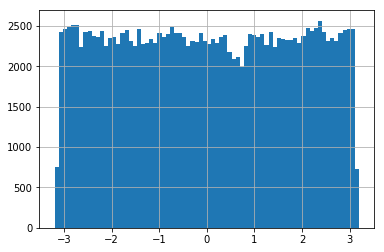

In [7]:
dataframes["WH_HtoRhoGammaPhiGamma"].query("recoPhi_phi > -999").recoPhi_phi.hist(bins=np.linspace(-3.2,3.2,75))

In [8]:
# Concatenate dataframes
data = pd.concat(dataframes.values())
        
# Get bookkeeping columns to exclude in training
excludes = ["signal", "stype", "run", "lumi", "event", "scale1fb",
           "recoMeson_nCands", "recoWLepton_nLep", "minGammaParton_dR"]
for bname in branches:
    if "gen" in bname: excludes.append(bname)
    elif "_mass" in bname: excludes.append(bname)
    elif "Rho" in bname: excludes.append(bname)

# Collect selected features
features = sorted(list(set(data.columns.values)-set(excludes)))

In [9]:
# Display selected features
print("Selected Feature Names:\n"+", ".join(features)+"\n")
# Display excluded features
print("Excluded Feature Names:\n"+", ".join(excludes))

Selected Feature Names:
recoGamma_eta, recoGamma_iso, recoGamma_phi, recoGamma_pt, recoKm_eta, recoKm_iso, recoKm_phi, recoKm_pt, recoKpKm_dR, recoKp_eta, recoKp_iso, recoKp_phi, recoKp_pt, recoPhi_eta, recoPhi_iso, recoPhi_phi, recoPhi_pt, recoPim_eta, recoPim_iso, recoPim_phi, recoPim_pt, recoPipPim_dR, recoPip_eta, recoPip_iso, recoPip_phi, recoPip_pt, recoWLepton_eta, recoWLepton_id, recoWLepton_phi, recoWLepton_pt

Excluded Feature Names:
signal, stype, run, lumi, event, scale1fb, recoMeson_nCands, recoWLepton_nLep, minGammaParton_dR, genRecoGamma_dR, genRecoPhi_dR, genRecoRho_dR, genW_pt, genW_eta, genW_phi, genW_mass, genWLepton_id, genWLepton_pt, genWLepton_eta, genWLepton_phi, genHiggs_pt, genHiggs_eta, genHiggs_phi, genHiggs_mass, genHiggsMeson_id, genHiggsMeson_pt, genHiggsMeson_eta, genHiggsMeson_phi, genHiggsMeson_mass, genHiggsMesonGamma_dR, genKm_pt, genKm_phi, genKm_eta, genKp_pt, genKp_phi, genKp_eta, genKpKm_dR, genGamma_pt, genGamma_phi, genGamma_eta, recoHiggs_mass,

In [10]:
# Weigh *_pt columns by reco Higgs mass
for col in data.columns:
    if "_pt" in col and col not in excludes:
        data[col] = np.where(data[col] != -999, data[col], data[col]/data["recoHiggs_mass"])

In [11]:
# Plot all columns separately for background and signal
# fig, axes = plt.subplots(6,6,figsize=(15,15))
# df = data[features+["signal"]][(data.stype == 0) | (data.stype == samples.index("TTGamma_SingleLeptFromTbar"))]
# ax = df[df.signal==0].hist(ax=axes.flatten()[:len(df.keys())],alpha=0.5,color="C0",ylabelsize=0,density=True,layout=(6,6),bins="auto")
# ax = df[df.signal==1].hist(ax=axes.flatten()[:len(df.keys())],alpha=0.5,color="C3",ylabelsize=0,density=True,layout=(6,6),bins="auto")

In [12]:
# Split dataframe for training and testing
dummyWeights = np.ones(len(data["signal"])) # in place of data["weights"]
x_train, x_test, y_train, y_test, stype_train, stype_test, weights_train, weights_test = train_test_split(
                data[features],
                data["signal"],
                data["stype"],
                dummyWeights,
                test_size=0.25, random_state=42,
                )

## Train BDT

In [13]:
dump_name = "rpg.h"

# Sample selection (stype == 0 <--> signal)
sel_test = ( (stype_test == 0) | (stype_test == samples.index("WJetsToLNu")) )
sel_train = ( (stype_train == 0) | (stype_train == samples.index("WJetsToLNu")) )

# BDT Input
dtrain = xgb.DMatrix( x_train, label=y_train, weight=np.abs(weights_train))
dtest = xgb.DMatrix( x_test, label=y_test, weight=np.abs(weights_test))
evallist  = [(dtrain,'train'), (dtest,'eval')]

# BDT Parameters Setup
param = {}
param['objective'] = 'binary:logistic'

# BDT Knobs (Parameters)
num_round = 200                 # Number of training rounds
param['eta'] = 0.1              # Step size shrinkage (alias: learning_rate)
param['max_depth'] = 4          # Max. depth of tree: larger = more complex = more prone to overfitting
param['verbosity'] = 1          # 0 (silent), 1 (warning), 2 (info), 3 (debug)
param['nthread'] = 4            # Number of parallel threads
param['eval_metric'] = "auc"    # Evaluation metrics for validation data. 'auc' = Area Under the Curve
param['subsample'] = 0.6        # Subsample ratio of the training instances
param['alpha'] = 8.0            # L1 regularization term on weights: Larger = more conservative
param['gamma'] = 2.0            # Min. loss rediction to make leaf (alias: min_split_loss)
param['lambda'] = 1.0           # L2 regularization term on weights: Larger = more conservative
param['min_child_weight'] = 1.0 # Minimum sum of instance weight (hessian) needed in a child
param['colsample_bytree'] = 1.0 # The subsample ratio of columns when constructing each tree

In [14]:
# Get pos/neg weights
sumw_pos = np.abs(dtrain.get_weight()[dtrain.get_label()==1]).sum()
sumw_neg = np.abs(dtrain.get_weight()[dtrain.get_label()==0]).sum()
param["scale_pos_weight"] = sumw_neg/sumw_pos

In [15]:
# Train
bst = xgb.train( param.items(), dtrain, num_round, evallist, early_stopping_rounds=15 )

[0]	train-auc:0.872637	eval-auc:0.869535
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 15 rounds.
[1]	train-auc:0.880209	eval-auc:0.877631
[2]	train-auc:0.88391	eval-auc:0.881426
[3]	train-auc:0.892884	eval-auc:0.890714
[4]	train-auc:0.897727	eval-auc:0.895835
[5]	train-auc:0.899009	eval-auc:0.896894
[6]	train-auc:0.899672	eval-auc:0.8976
[7]	train-auc:0.900723	eval-auc:0.898383
[8]	train-auc:0.902823	eval-auc:0.900634
[9]	train-auc:0.903972	eval-auc:0.901801
[10]	train-auc:0.904458	eval-auc:0.902129
[11]	train-auc:0.904872	eval-auc:0.902533
[12]	train-auc:0.905704	eval-auc:0.903448
[13]	train-auc:0.90631	eval-auc:0.904161
[14]	train-auc:0.907135	eval-auc:0.904912
[15]	train-auc:0.907743	eval-auc:0.905617
[16]	train-auc:0.908249	eval-auc:0.906148
[17]	train-auc:0.908695	eval-auc:0.906481
[18]	train-auc:0.909257	eval-auc:0.9071
[19]	train-auc:0.909833	eval-auc:0.90772
[20]	train-auc:0.910348	eval-auc:0.9

[191]	train-auc:0.94909	eval-auc:0.945242
[192]	train-auc:0.949262	eval-auc:0.945427
[193]	train-auc:0.949362	eval-auc:0.945533
[194]	train-auc:0.94949	eval-auc:0.945649
[195]	train-auc:0.949632	eval-auc:0.945777
[196]	train-auc:0.949781	eval-auc:0.945914
[197]	train-auc:0.950069	eval-auc:0.946175
[198]	train-auc:0.950136	eval-auc:0.94623
[199]	train-auc:0.950245	eval-auc:0.946319


In [16]:
# Get predictions
preds_train = bst.predict(xgb.DMatrix(x_train))
preds_test = bst.predict(xgb.DMatrix(x_test))

## Evaluate Performance

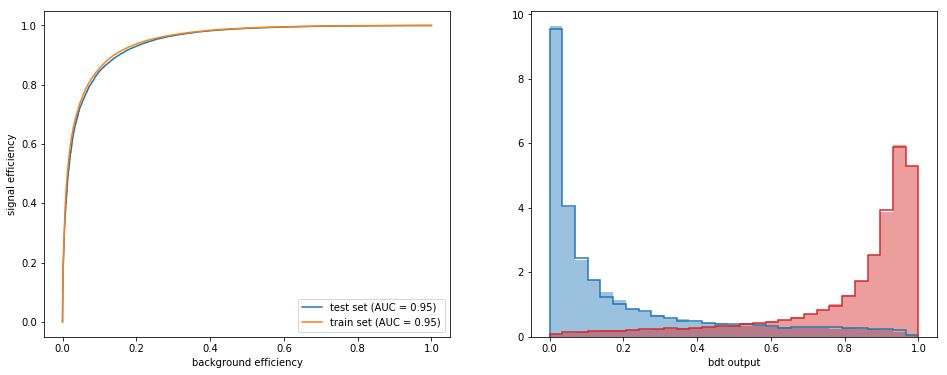

In [17]:
# Suplots setup
fig, axes = plt.subplots(1,2,figsize=(16,6))

# Subplot 1: Plot ROC curves
plt.subplot(1, 2, 1)
# Test ROC Curve
fpr, tpr, thresh = roc_curve(y_test,preds_test)
plt.plot(fpr, tpr, label="test set (AUC = {:.2f})".format(np.trapz(tpr,fpr)));
# Train ROC Curve
fpr, tpr, thresh = roc_curve(y_train,preds_train)
plt.plot(fpr, tpr, label="train set (AUC = {:.2f})".format(np.trapz(tpr,fpr)));
# Settings
plt.xlabel("background efficiency");
plt.ylabel("signal efficiency");
plt.legend();

# Subplot 2: Plot distribution of BDT outputs
plt.subplot(1, 2, 2)
bins = np.linspace(0.,1.,30)
# Training - Background
plt.hist(preds_train[y_train==0], weights=weights_train[y_train==0], bins=bins,histtype="stepfilled",alpha=0.45, density=True, label="bkg, train",color="C0");
# Training - Signal
plt.hist(preds_train[y_train==1], weights=weights_train[y_train==1], bins=bins,histtype="stepfilled",alpha=0.45, density=True, label="sig, train",color="C3");
# Testing - Background
plt.hist(preds_test[y_test==0], weights=weights_test[y_test==0], bins=bins,histtype="step",alpha=1.0, density=True, label="bkg, test",color="C0", lw=1.5, linestyle="solid");
# Testing - Signal
plt.hist(preds_test[y_test==1], weights=weights_test[y_test==1], bins=bins,histtype="step",alpha=1.0, density=True, label="sig, test",color="C3", lw=1.5, linestyle="solid");
# Settings
plt.xlabel("bdt output");

In [18]:
# Get cut scores
scores = bst.get_score(importance_type='gain')
# Print as table
length = 0
for key, val in scores.iteritems():
    val = str(val)
    if len(key) > length:
        length = len(key)
    if len(val) > length:
        length = len(val)
print ("| Cut{0:{length}} | Gain{0:<{length}}|".format("", length=length-3))
for cut, gain in sorted(scores.items(), key=lambda kv:kv[1]):
    toPrint = "| {0:<{length}} | {1:<{length}} |".format(cut, gain, length=length)
    print("| "+"-"*length+" | "+"-"*length+" | ")
    print(toPrint)

| Cut             | Gain            |
| --------------- | --------------- | 
| recoPim_pt      | 11.1239263057   |
| --------------- | --------------- | 
| recoPip_pt      | 12.4251943292   |
| --------------- | --------------- | 
| recoKp_eta      | 14.5565934992   |
| --------------- | --------------- | 
| recoKm_eta      | 14.9082948315   |
| --------------- | --------------- | 
| recoPip_eta     | 15.8777043809   |
| --------------- | --------------- | 
| recoPhi_eta     | 17.0577479528   |
| --------------- | --------------- | 
| recoKm_iso      | 18.1327319036   |
| --------------- | --------------- | 
| recoPim_eta     | 19.7478214378   |
| --------------- | --------------- | 
| recoGamma_eta   | 20.5480934057   |
| --------------- | --------------- | 
| recoKpKm_dR     | 23.4229199153   |
| --------------- | --------------- | 
| recoKp_iso      | 23.44504699     |
| --------------- | --------------- | 
| recoWLepton_eta | 24.2983168071   |
| --------------- | --------------- | 

## Save BDT

In [20]:
# Write to JSON
WriteJSON("bdt.json", bst, features)
JSONtoC("bdt.json", "bdt.h")
# Write to pickle file
pickle.dump(bst, open("bdt.pkl", "w"))